In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import pickle
from urllib.parse import unquote
from torch.utils.data import Dataset, random_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATv2Conv, global_mean_pool, GraphNorm
from tqdm import tqdm
import random
from torch_geometric.nn.models import GAT
import matplotlib.pyplot as plt
from collections import Counter

# Load Data

In [66]:
# Load text data
data = pd.read_csv(f"../../data/full_text_data.csv")

In [67]:
# Load links
links = pd.read_csv("../../data/Wikispeedia/links.tsv", sep="\t", names=["src", "tgt"], skiprows=12)
links["src"] = links["src"].map(lambda x: unquote(x))
links["tgt"] = links["tgt"].map(lambda x: unquote(x))

# Create adjacency matrix
ordered_data_titles = data["title"].tolist()
src_indices = links["src"].map(lambda x: ordered_data_titles.index(x))
tgt_indices = links["tgt"].map(lambda x: ordered_data_titles.index(x))
A = torch.zeros((len(ordered_data_titles), len(ordered_data_titles)))
A[src_indices, tgt_indices] = 1

In [68]:
# Load coherence graph
with open("../../data/coherence_graph.pkl", 'rb') as handle:
    coherence_graph = pickle.load(handle)

# Combine coherence graph with base links
edge_features = A * coherence_graph

In [2]:
# Load node embeddings
with open("../../data/gpt4_embeddings.pkl", 'rb') as handle:
    obj = pickle.load(handle)
    node_static_embeddings = obj["embeddings"]
    del obj
node_static_embeddings = torch.tensor(node_static_embeddings, dtype=torch.float)

/var/folders/62/lfsj8yr93_31q1svnw13n2km0000gn/T/ipykernel_36520/3588909332.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_static_embeddings = torch.tensor(node_static_embeddings, dtype=torch.float)


In [3]:
node_static_embeddings.shape[1]

1536

In [70]:
#!FIXME THIS NEEDS TO BE FIXED HERE, USE THE TRAIN/VAL/TEST SPLIT BECAUSE NOBODY ELSE DID

# Load user-extracted paths
paths_data = pd.read_csv(f"../../data/paths_no_back_links.tsv", sep="\t")
paths_data = paths_data[~(paths_data["rating"].isna())]

# Only paths with that have at least two distinct pages between the source and the the target
paths_data = paths_data[paths_data["path"].apply(lambda x: len(set(x.split(";")))) >= 4]
paths_data = paths_data[paths_data["path"].apply(lambda x: len(set(x.split(";")))) <= 100]

# Map titles to indices
title_to_index = {unquote(title): idx for idx, title in enumerate(data['title'])}
paths = paths_data['path'].apply(lambda path: [title_to_index[unquote(title)] for title in path.split(';')]).tolist()
ratings = (paths_data['rating'] - 1).tolist()  # 0-indexed ratings
# ratings = [0 if r < 2 else 1 for r in ratings]
durations = paths_data['durationInSec']

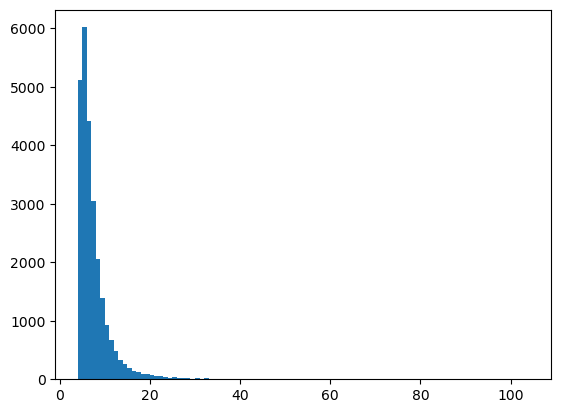

In [73]:
cnt = Counter([len(p.split(';')) for p in paths_data['path']])
#print(cnt)
plt.hist([len(p.split(';')) for p in paths_data['path']], bins=100)
plt.show()

[2.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 4.0, 1.0, 2.0, 2.0, 3.0, 0.0, 0.0, 1.0, 2.0, 2.0, 3.0, 2.0, 1.0, 4.0, 2.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 3.0, 3.0, 3.0, 0.0, 1.0, 1.0, 1.0, 3.0, 2.0, 4.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 3.0, 4.0, 2.0, 2.0, 3.0, 1.0, 3.0, 1.0, 2.0, 1.0, 2.0, 3.0, 3.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 0.0, 1.0, 2.0, 4.0, 3.0, 4.0, 1.0, 3.0, 2.0, 2.0, 0.0, 2.0, 1.0, 1.0, 2.0, 4.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 3.0, 0.0, 1.0, 2.0, 2.0, 2.0, 3.0, 1.0, 2.0, 2.0, 1.0, 2.0, 4.0, 0.0, 0.0, 3.0, 0.0, 4.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 3.0, 0.0, 0.0, 2.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 0.0, 3.0, 2.0, 1.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 4.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 4.0, 2.0, 2.0, 4.0, 3.0, 2.0, 2.0, 3.0, 4.0, 2.0, 3.0, 4.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 3.0, 1.0,

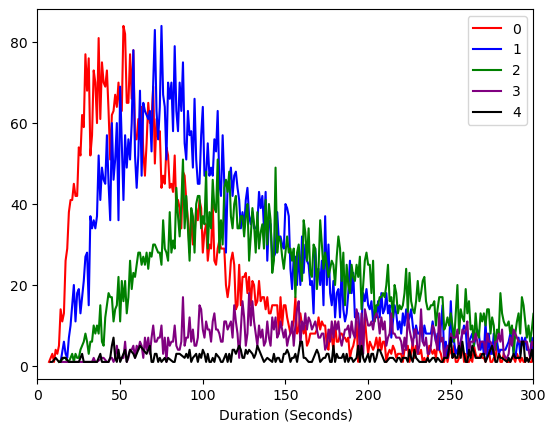

In [74]:
print(ratings)
print(durations.to_list())

cnt = Counter(zip(ratings,durations))
sorted_counter = sorted(cnt.keys(), key=lambda item: item[1], reverse=False)
print(sorted_counter)
x = [x[1] for x in sorted_counter if x[0] == 0.0]
y = [cnt[x] for x in sorted_counter if x[0] == 0.0]
plt.plot(x, y, label=0, color='red')
x = [x[1] for x in sorted_counter if x[0] == 1.0]
y = [cnt[x] for x in sorted_counter if x[0] == 1.0]
plt.plot(x, y, label=1, color='blue')
x = [x[1] for x in sorted_counter if x[0] == 2.0]
y = [cnt[x] for x in sorted_counter if x[0] == 2.0]
plt.plot(x, y, label=2, color='green')
x = [x[1] for x in sorted_counter if x[0] == 3.0]
y = [cnt[x] for x in sorted_counter if x[0] == 3.0]
plt.plot(x, y, label=3, color='purple')
x = [x[1] for x in sorted_counter if x[0] == 4.0]
y = [cnt[x] for x in sorted_counter if x[0] == 4.0]
plt.plot(x, y, label=4, color='black')

plt.xlabel('Duration (Seconds)')
plt.legend()
plt.xlim(0,300)
plt.show()

In [75]:
class PathDataset(Dataset):
    def __init__(self, paths, ratings, durations, node_embeddings, edge_features):
        self.paths = paths
        self.ratings = ratings
        self.durations = durations
        self.node_embeddings = node_embeddings
        self.edge_features = edge_features

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        rating = self.ratings[idx]
        nodes, edge_index, edge_weight = self.get_subgraph_edges(path)

        x = self.node_embeddings[nodes]

        data = Data(
            x=x,
            edge_index=edge_index,
            edge_weight=edge_weight,
            y=torch.tensor([rating], dtype=torch.long)
        )
        return data, torch.tensor(self.durations.values[idx])

    def get_subgraph_edges(self, path):
        nodes = list(set(path))
        node_to_idx = {node: idx for idx, node in enumerate(nodes)}
        edges = []
        edge_weights = []
        for i in nodes:
            for j in nodes:
                weight = self.edge_features[i, j]
                if weight > 0:
                    edges.append([node_to_idx[i], node_to_idx[j]])
                    edge_weights.append(weight)
        if edges:
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
            edge_weight = torch.tensor(edge_weights, dtype=torch.float)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_weight = torch.tensor([], dtype=torch.float)
        return nodes, edge_index, edge_weight

# Create dataset
dataset = PathDataset(paths, ratings, durations, node_static_embeddings, edge_features)

# Split dataset
train_ratio = 0.85
val_ratio = 0.05
test_ratio = 0.1
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/Users/trevorashby/miniconda3/envs/graph-ml/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [99]:
dataset[0]

(Data(x=[5, 1536], edge_index=[2, 6], y=[1], edge_weight=[6]), tensor(88))

In [80]:
class PathDataset(Dataset):
    def __init__(self, all_padded_paths, ratings, durations, node_static_embeddings, edge_features):
        self.all_padded_paths = all_padded_paths
        self.ratings = ratings
        self.durations = durations
        self.node_static_embeddings = node_static_embeddings
        self.edge_features = edge_features

    def __len__(self):
        return len(self.all_padded_paths)

    def __getitem__(self, idx):
        path = self.all_padded_paths[idx]
        rating = self.ratings[idx]

        # Extract the 1-hop neighborhood subgraph
        neighbors, in_path, subgraph, edges = self.get_path_1hop_neighborhood(
            path,
            self.edge_features
        )

        # Get node features
        node_features = self.node_static_embeddings[neighbors]

        # Create edge index tensor
        if len(edges) > 0:
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)

        # Create the Data object
        node_data = Data(
            x=node_features,
            edge_index=edge_index,
            y=torch.tensor([rating], dtype=torch.long),
            in_path=torch.tensor(in_path, dtype=torch.long),
            # We convert the subgraph to numpy to avoid issues with PyTorch's Data collation,
            # since the subgraphs have shape NxN, instead of NxD. That is they do not have
            # fixed feature dimensionality in the columns. The columns vary with the rows.
            adj=subgraph.numpy()
        )

        return node_data, torch.tensor(self.durations.values[idx])

    def get_path_1hop_neighborhood(self, path, edge_features, do_shuffle=False):
        path_nodes = set(path)

        # Collect 1-hop neighbors in a set to avoid duplicates
        neighbors = set()
        for node in path:
            # Get the indices of the top 4 neighbors with the highest edge weights
            top_neighbors = torch.topk(edge_features[node], k=4, largest=True).indices.tolist()
            neighbors.update(top_neighbors)

        all_nodes = list(path_nodes | neighbors)

        if do_shuffle:
            random.shuffle(all_nodes)

        # Extract subgraph using tensor indexing
        indices = torch.tensor(all_nodes)
        subgraph = edge_features.index_select(0, indices).index_select(1, indices)

        # Create a binary list indicating if each node is in the path
        is_in_path = [1 if node in path_nodes else 0 for node in all_nodes]

        # Edge list from non-zero entries in the subgraph
        edge_indices = (subgraph != 0).nonzero(as_tuple=False)
        edge_list = [(src.item(), tgt.item()) for src, tgt in edge_indices]

        return all_nodes, is_in_path, subgraph, edge_list

# Create dataset
dataset = PathDataset(paths, ratings, durations, node_static_embeddings, edge_features)

# Split dataset
train_ratio = 0.85
val_ratio = 0.05
test_ratio = 0.1
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# GAT model

In [76]:
#! FIXME MODIFY THIS MODEL TO ACTUALLY USE GAT LAYERS, NOT GCN

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_classes, num_heads=3, dropout=0.1):
        super(GATModel, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=num_heads,
                               dropout=0.1)#, edge_dim=1)
        self.norm1 = GraphNorm(hidden_channels*num_heads)
        self.conv2 = GATv2Conv(hidden_channels*num_heads, out_channels, heads=num_heads,
                               dropout=0.1)#, edge_dim=1)
        self.norm2 = GraphNorm(out_channels*num_heads)
        self.classifier = torch.nn.Linear((out_channels*num_heads)+1, num_classes)
        self.dropout = dropout

    def forward(self, data, durations):
        # x, edge_index = data.x, data.edge_index
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight

        x = self.conv1(x, edge_index)
                       #,edge_attr=edge_weight)
        x = self.norm1(x)
        x = F.leaky_relu(x, 0.1)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
                       #, edge_attr=edge_weight)
        x = self.norm2(x)
        x = F.leaky_relu(x, 0.1)

        x = global_mean_pool(x, batch=data.batch)
        #print(x.shape)
        #print(durations.unsqueeze(1).shape)
        x = torch.cat((x,durations.unsqueeze(1)),dim=1)
        #print(x.shape)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

# Training

In [77]:
# Counts occurrences of each class
class_counts = torch.bincount(
    torch.tensor(ratings)[train_dataset.indices].to(torch.int64)
)

# Calculate weights as the inverse of class frequencies
class_weights = 1.0 / class_counts.float()

# Normalize the weights so that they sum to the number of classes
class_weights = class_weights / class_weights.sum() * len(class_counts)

class_weights

tensor([0.4408, 0.3370, 0.3945, 1.0287, 2.7991])

In [82]:
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
model = GATModel(
    in_channels=node_static_embeddings.shape[1],
    hidden_channels=64,
    out_channels=32,
    num_heads=4,
    num_classes=5  # Assuming ratings are from 1 to 5
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

def train():
    model.train()
    total_loss = 0
    for data, duration in tqdm(train_loader):
        data = data.to(device)
        duration = duration.to(device)
        optimizer.zero_grad()
        out = model(data, duration)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0

    confusion_matrix = np.array([[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]])
    with torch.no_grad():
        for data, duration in loader:
            data = data.to(device)
            out = model(data, duration)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.num_graphs

            for idx in range(data.y.shape[0]):
                confusion_matrix[data.y[idx], pred[idx]] += 1

    print(data.y.shape)
    print(pred.shape)

    return (correct / total), confusion_matrix

best_val_acc = 0
for epoch in range(1, 10):
    loss = train()
    val_acc, conf_mat = evaluate(val_loader)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

  0%|          | 0/344 [00:00<?, ?it/s]

/var/folders/62/lfsj8yr93_31q1svnw13n2km0000gn/T/ipykernel_99870/273455421.py:35: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y=torch.tensor([rating], dtype=torch.long),
100%|██████████| 344/344 [04:48<00:00,  1.19it/s]


torch.Size([14])
torch.Size([14])
Epoch: 001, Loss: 2.0592, Val Acc: 0.3926


100%|██████████| 344/344 [05:37<00:00,  1.02it/s]


torch.Size([14])
torch.Size([14])
Epoch: 002, Loss: 1.6040, Val Acc: 0.3980


100%|██████████| 344/344 [05:33<00:00,  1.03it/s]


torch.Size([14])
torch.Size([14])
Epoch: 003, Loss: 1.5971, Val Acc: 0.2457


100%|██████████| 344/344 [06:04<00:00,  1.06s/it]


torch.Size([14])
torch.Size([14])
Epoch: 004, Loss: 1.6112, Val Acc: 0.2968


100%|██████████| 344/344 [04:58<00:00,  1.15it/s]


torch.Size([14])
torch.Size([14])
Epoch: 005, Loss: 1.6233, Val Acc: 0.3215


 50%|████▉     | 171/344 [02:34<02:35,  1.11it/s]


KeyboardInterrupt: 

In [14]:
HIDDEN = 64
OUTPUT = 32
HEADS = 4

model = GATModel(
    in_channels=node_static_embeddings.shape[1],
    hidden_channels=HIDDEN,
    out_channels=OUTPUT,
    num_heads=HEADS,
    num_classes=2  # Assuming ratings are from 1 to 5
).to(device)

# Load the best model
model.load_state_dict(torch.load(f'./not_topk/binary_best_model_{HIDDEN}_{OUTPUT}_{HEADS}.pth'))

test_acc, conf_mat = evaluate(test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

torch.Size([30])
torch.Size([30])
Test Accuracy: 0.7023


In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def conf_matrix(model, dataset_loader):
    # Pass the testing loader through the model
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch, duration in dataset_loader:
            logits = model(batch, duration)
            preds = logits.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

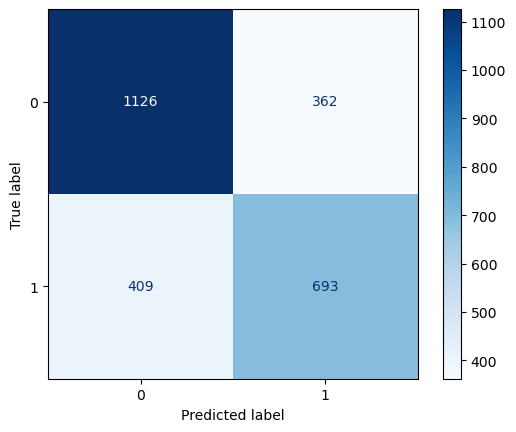

In [16]:
conf_matrix(model, test_loader)

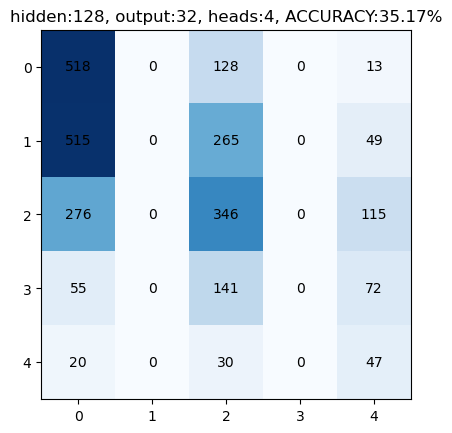

In [70]:
fig, ax = plt.subplots()
im = ax.imshow(conf_mat, cmap=plt.cm.Blues)

plt.title(f'hidden:{HIDDEN}, output:{OUTPUT}, heads:{HEADS}, ACCURACY:{test_acc*100:.2f}%')
# Loop over data dimensions and create text annotations.
for i in range(5):
    for j in range(5):
        text = ax.text(j, i, conf_mat[i, j],
                       ha="center", va="center", color="k")

In [63]:
for i in range(len(dataset)):
    print(dataset[i])

/var/folders/62/lfsj8yr93_31q1svnw13n2km0000gn/T/ipykernel_37397/814452473.py:24: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y=torch.tensor([rating], dtype=torch.long)


(Data(x=[5, 1536], edge_index=[2, 6], y=[1]), tensor(88))
(Data(x=[7, 1536], edge_index=[2, 10], y=[1]), tensor(175))
(Data(x=[4, 1536], edge_index=[2, 4], y=[1]), tensor(112))
(Data(x=[6, 1536], edge_index=[2, 16], y=[1]), tensor(139))
(Data(x=[4, 1536], edge_index=[2, 5], y=[1]), tensor(74))
(Data(x=[12, 1536], edge_index=[2, 38], y=[1]), tensor(253))
(Data(x=[10, 1536], edge_index=[2, 19], y=[1]), tensor(218))
(Data(x=[11, 1536], edge_index=[2, 26], y=[1]), tensor(391))
(Data(x=[7, 1536], edge_index=[2, 8], y=[1]), tensor(387))
(Data(x=[10, 1536], edge_index=[2, 16], y=[1]), tensor(179))
(Data(x=[8, 1536], edge_index=[2, 15], y=[1]), tensor(345))
(Data(x=[7, 1536], edge_index=[2, 12], y=[1]), tensor(265))
(Data(x=[4, 1536], edge_index=[2, 5], y=[1]), tensor(75))
(Data(x=[7, 1536], edge_index=[2, 15], y=[1]), tensor(153))
(Data(x=[4, 1536], edge_index=[2, 4], y=[1]), tensor(47))
(Data(x=[8, 1536], edge_index=[2, 14], y=[1]), tensor(383))
(Data(x=[6, 1536], edge_index=[2, 10], y=[1]),

KeyboardInterrupt: 